In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [2]:
# Set the path to the train and test directories
train_data_dir = 'D:/data_split/train'
test_data_dir = 'D:/data_split/test'

# Set the number of classes and image dimensions
num_classes = 13
image_size = (96, 96)
batch_size = 8
class_names = [
    'Andorra_2019',
    'Common',
    'Lithuania_2021',
    'Monaco_2015',
    'Monaco_2016',
    'Monaco_2017',
    'Monaco_2018',
    'Monaco_2019',
    'SanMarino_2004',
    'SanMarino_2005',
    'Vatican_2004',
    'Vatican_2005',
    'Vatican_2006'
]


# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Normalization for testing/validation
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators for loading the train and test images
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    classes = class_names,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=42,
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    classes = class_names,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=42,
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    classes = class_names,
    batch_size=batch_size,
    class_mode='categorical',
    #seed=42,
    shuffle=False
)



Found 3367 images belonging to 13 classes.
Found 830 images belonging to 13 classes.
Found 474 images belonging to 13 classes.


In [3]:
# Load the pre-trained MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze the weights of the pre-trained layers so they are not updated during training
for layer in base_model.layers:
    layer.trainable = False

# Build the improved CNN model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 256)               2359552   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 13)                3341      
                                                                 
Total params: 5,591,757
Trainable params: 2,362,893
Non-trainable params: 3,228,864
______________________________________

In [4]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Set the number of training and validation steps per epoch
train_steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps_per_epoch = validation_generator.n // validation_generator.batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=validation_generator,
    validation_steps=validation_steps_per_epoch
)

# Evaluate the model on the test dataset
test_steps_per_epoch = test_generator.n // test_generator.batch_size
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps_per_epoch)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
420/420 [==============================] - 85s 177ms/step - loss: 1.6534 - accuracy: 0.5561 - val_loss: 0.4491 - val_accuracy: 0.8726
Epoch 2/10
420/420 [==============================] - 71s 170ms/step - loss: 0.6795 - accuracy: 0.7532 - val_loss: 0.4775 - val_accuracy: 0.8532
Epoch 3/10
420/420 [==============================] - 61s 145ms/step - loss: 0.5393 - accuracy: 0.8086 - val_loss: 0.3844 - val_accuracy: 0.8835
Epoch 4/10
420/420 [==============================] - 44s 105ms/step - loss: 0.3908 - accuracy: 0.8583 - val_loss: 0.2953 - val_accuracy: 0.9017
Epoch 5/10
420/420 [==============================] - 44s 104ms/step - loss: 0.3729 - accuracy: 0.8645 - val_loss: 0.3943 - val_accuracy: 0.9211
Epoch 6/10
420/420 [==============================] - 43s 103ms/step - loss: 0.3752 - accuracy: 0.8714 - val_loss: 0.5005 - val_accuracy: 0.8786
Epoch 7/10
420/420 [==============================] - 43s 103ms/step - loss: 0.3817 - accuracy: 0.8696 - val_loss: 0.4531 - val_ac

In [17]:
#saving model
model.save('C:/Users/spoor/Documents/Jupyter-works/mobilenet_model_96/mobilenet_model_96.h5')

model.save_weights('C:/Users/spoor/Documents/Jupyter-works/mobilenet_model_96/mobilenet_model_96_weights.h5')

#extracting saved model
model = tf.keras.models.load_model('C:/Users/spoor/Documents/Jupyter-works/mobilenet_model/mobilenet_model2.h5')
model.load_weights('C:/Users/spoor/Documents/Jupyter-works/mobilenet_model/mobilenet_model2_weights.h5')
model.summary()

60/60 [==============================] - 4s 59ms/step


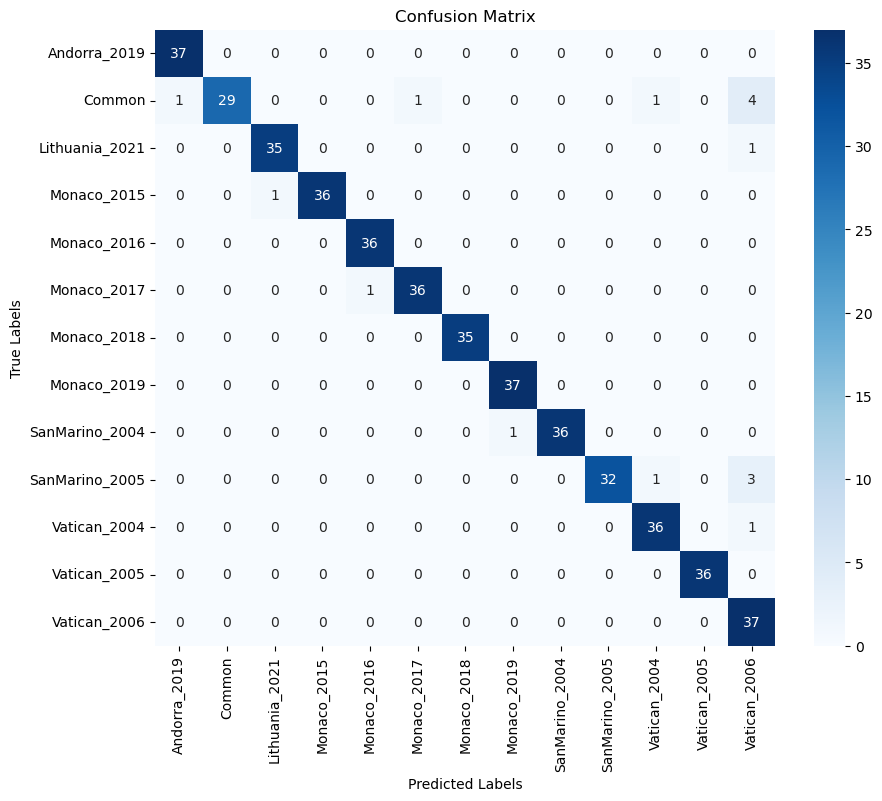

In [6]:
# Get the true labels for the test set
test_true_labels = test_generator.classes

# Predict the labels for the test set
test_pred_probs = model.predict(test_generator)
test_pred_labels = np.argmax(test_pred_probs, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(test_true_labels, test_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

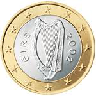

In [7]:
img = tf.keras.preprocessing.image.load_img('D:/common-test.jpg', target_size=(96, 96))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array]) 
img

In [8]:
# generate predictions for samples
predictions = model.predict(img_array)
print(predictions)

1/1 [==============================] - 1s 821ms/step
[[1.6000864e-14 9.9977368e-01 8.9407575e-09 3.1524316e-09 1.0927216e-11
  2.4281127e-11 4.0809900e-07 8.7828946e-12 5.0416139e-07 4.6632880e-12
  2.2539723e-04 7.8660539e-10 2.9051832e-15]]


In [9]:
# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)
print(class_id)

# transform classes number into classes name
class_names[class_id.item()]

[1]


'Common'

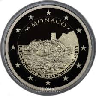

In [10]:
img = tf.keras.preprocessing.image.load_img('D:/monaco_2015.jpg', target_size=(96, 96))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array]) 
img

In [11]:
predictions = model.predict(img_array)
print(predictions)

1/1 [==============================] - 0s 53ms/step
[[4.2072704e-21 4.0134820e-09 3.1361300e-16 8.8078755e-14 5.5435045e-16
  2.2024400e-23 1.5621335e-15 1.7573070e-21 4.6235405e-18 3.6602487e-15
  1.0000000e+00 3.5966943e-09 1.4406399e-19]]


In [12]:
# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)
print(class_id)

# transform classes number into classes name
class_names[class_id.item()]

[10]


'Vatican_2004'

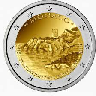

In [13]:
img = tf.keras.preprocessing.image.load_img('D:/8.jpg', target_size=(96, 96))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array]) 
img



In [14]:
predictions = model.predict(img_array)
print(predictions)

# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)
print(class_id)

# transform classes number into classes name
class_names[class_id.item()]

1/1 [==============================] - 0s 53ms/step
[[2.3383170e-15 2.9740769e-02 3.3669328e-11 1.2843022e-10 2.1221778e-11
  3.6536275e-15 4.0884754e-11 1.4420778e-14 1.5773494e-10 3.0571660e-11
  9.7025925e-01 9.1107433e-09 7.9225261e-17]]
[10]


'Vatican_2004'

In [18]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Set the number of training and validation steps per epoch
train_steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps_per_epoch = validation_generator.n // validation_generator.batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=20,  # Adjust the number of epochs as needed
    validation_data=validation_generator,
    validation_steps=validation_steps_per_epoch
)

# Evaluate the model on the test dataset
test_steps_per_epoch = test_generator.n // test_generator.batch_size
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps_per_epoch)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/20
420/420 [==============================] - 48s 108ms/step - loss: 0.3060 - accuracy: 0.9256 - val_loss: 0.3395 - val_accuracy: 0.9296
Epoch 2/20
420/420 [==============================] - 44s 105ms/step - loss: 0.3169 - accuracy: 0.9312 - val_loss: 0.3905 - val_accuracy: 0.9357
Epoch 3/20
420/420 [==============================] - 44s 105ms/step - loss: 0.2719 - accuracy: 0.9244 - val_loss: 0.5054 - val_accuracy: 0.9272
Epoch 4/20
420/420 [==============================] - 45s 106ms/step - loss: 0.2497 - accuracy: 0.9253 - val_loss: 0.4320 - val_accuracy: 0.9308
Epoch 5/20
420/420 [==============================] - 45s 106ms/step - loss: 0.3098 - accuracy: 0.9166 - val_loss: 0.6921 - val_accuracy: 0.9114
Epoch 6/20
420/420 [==============================] - 45s 107ms/step - loss: 0.2475 - accuracy: 0.9211 - val_loss: 0.4520 - val_accuracy: 0.9308
Epoch 7/20
420/420 [==============================] - 45s 106ms/step - loss: 0.3327 - accuracy: 0.9193 - val_loss: 0.6904 - val_ac

In [1]:
#saving model
model.save('C:/Users/spoor/Documents/Jupyter-works/mobilenet_model_98/mobilenet_model_98.h5')

model.save_weights('C:/Users/spoor/Documents/Jupyter-works/mobilenet_model_98/mobilenet_model_98_weights.h5')

NameError: name 'model' is not defined